In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
from sklearn import preprocessing
from torch import nn
import torch
from torch.utils.data import Subset, DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from utils import Utils
utils = Utils()

In [25]:
metric = 'AUCPR'

In [26]:
result = pd.read_csv('result/result_' + metric + '_small.csv')
result.rename(columns={'Unnamed: 0':'Components'}, inplace=True)

In [27]:
print(f'原始数据, 模型数&数据集个数: {result.shape}')

result.dropna(axis=1, thresh=int(0.5*(result.shape[0])), inplace=True)
print(f'去除大多数模型(50%以上)fail的数据集后, 模型数&数据集个数: {result.shape}')

columns_select = []
for c in result.columns[1:]:
    result_sub = result[['Components', c]]
    
    if any(result_sub[['FTT' in ast.literal_eval(_).values() for _ in result_sub['Components']]].iloc[:, 1].isnull()):
        continue
    else:
        columns_select.append(c)
        
result = result[['Components'] + columns_select]
print(f'去除FTT fail的几个数据集, 模型数&数据集个数: {result.shape}')

result.dropna(axis=0, how='any',inplace=True)
print(f'去除在有fail情况的components, 模型数&数据集个数: {result.shape}')

原始数据, 模型数&数据集个数: (100, 36)
去除大多数模型(50%以上)fail的数据集后, 模型数&数据集个数: (100, 35)
去除FTT fail的几个数据集, 模型数&数据集个数: (100, 23)
去除在有fail情况的components, 模型数&数据集个数: (81, 23)


In [28]:
# 只显示不一样的components
Components_list = [ast.literal_eval(_) for _ in result['Components']]
keys = list(ast.literal_eval(result['Components'][0]).keys())
keys_show = []

for k in keys:
    options = [str(_[k]) for _ in Components_list if _[k] is not None]
    
    if len(set(options)) == 1 or len(options) == 0:
        continue
    else:
        keys_show.append(k)

In [29]:
# 能否学习components? (学习一个简单的classifier)
components_list = []
for c in [ast.literal_eval(_) for _ in result['Components']]:
    components_list.append({k:c[k] for k in keys_show})
components_df = pd.DataFrame(components_list)
components_df_index = components_df.copy()

for col in components_df_index.columns:
    components_df_index[col] = preprocessing.LabelEncoder().fit_transform(components_df_index[col])

In [30]:
components_df_index

,network_architecture,act_fun,loss_name,optimizer_name,batch_resample,lr
0,2,1,2,1,0,0
1,0,2,1,0,1,1
2,0,1,1,0,1,0
3,0,0,2,0,0,0
4,2,2,0,2,1,0
...,...,...,...,...,...,...
76,0,2,3,1,1,0
77,3,1,1,2,1,1
78,2,1,1,1,1,1
79,1,1,1,1,1,1


In [31]:
class meta_classifier(nn.Module):
    def __init__(self, n_col, n_per_col, embedding_dim=3):
        super(meta_classifier, self).__init__()

        self.embeddings = nn.ModuleList([nn.Embedding(int(n_per_col[i]), embedding_dim) for i in range(n_col)])
        self.classifier = nn.Sequential(
                            nn.Linear(n_col * embedding_dim, 20),
                            nn.ReLU(),
                            nn.Linear(20, 1),
                            nn.Sigmoid())
    
    def forward(self, X):
        assert X.size(1) == len(self.embeddings)
        
        embedding_list = []
        for i, e in enumerate(self.embeddings):
            embedding_list.append(e(X[:, i].long()))
        
        embedding = torch.cat(embedding_list, dim=1)
        pred = self.classifier(embedding)
        
        return embedding, pred

In [32]:
X = torch.from_numpy(components_df_index.values).float()
y = torch.from_numpy(result.iloc[:, 1:].apply(np.mean, axis=1).values).float()

utils.set_seed(42)
model = meta_classifier(n_col=X.size(1), n_per_col=[max(X[:, i]).item()+1 for i in range(X.size(1))])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_loader = DataLoader(TensorDataset(X, y), batch_size=6, shuffle=True, drop_last=True)

In [33]:
criterion = nn.MSELoss()
epochs = 500

loss_epoch = []
for i in tqdm(range(epochs)):
    loss_batch = []
    for batch in train_loader:
        batch_X, batch_y = batch
        
        # clear grad
        model.zero_grad()
        
        # loss forward
        _, pred = model(batch_X)
        loss = criterion(pred.squeeze(), batch_y)
        
        # loss backward
        loss.backward()
        
        # update
        optimizer.step()
        
        loss_batch.append(loss.item())
    
    loss_epoch.append(np.mean(loss_batch))
        
#     print(f'Epoch: {i}--Loss: {np.mean(loss_batch)}')

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:07<00:00, 64.90it/s]


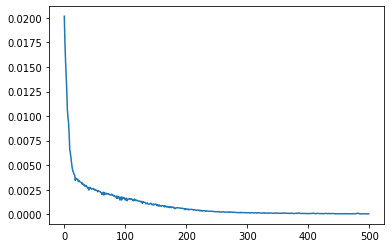

In [34]:
plt.plot(loss_epoch)

In [66]:
with torch.no_grad():
    embedding, pred = model(X)
embedding_tsne = TSNE(n_components=2, random_state=42).fit_transform(embedding)
# embedding_tsne = PCA(n_components=2, random_state=42).fit_transform(embedding)

F:\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
F:\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


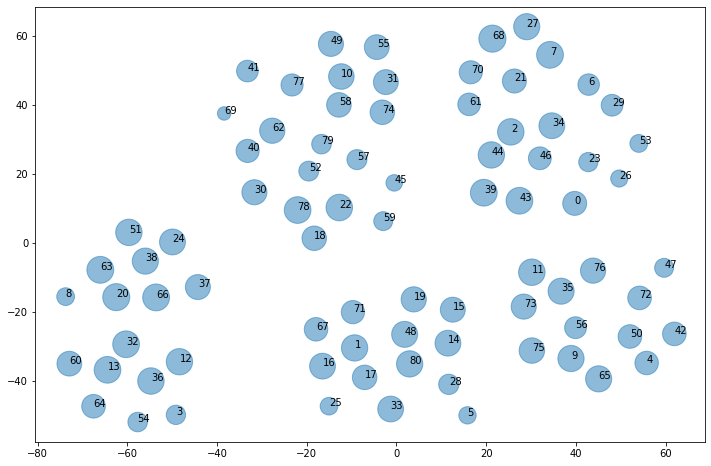

In [68]:
plt.figure(figsize=(12, 8))
plt.scatter(embedding_tsne[:, 0], embedding_tsne[:, 1], s=y*1000, alpha=0.5)
for i, (xx, yy) in enumerate(zip(embedding_tsne[:, 0], embedding_tsne[:, 1])):
    plt.text(xx, yy, str(i))

In [64]:
result.iloc[:, 1:].apply(np.mean, axis=1).values[[0, 39, 43]]

array([0.57567561, 0.71756222, 0.71445401])

分析components

In [6]:
# Current SOTA model (semi-supervised)
result_SOTA_semi = pd.read_csv('result/' + metric + '_SOTA_semi-supervise.csv')
result_SOTA_semi.rename(columns={'Unnamed: 0':'Params'}, inplace=True)

params = [ast.literal_eval(_) for _ in result_SOTA_semi['Params']]
result_SOTA_semi = result_SOTA_semi[[_[1] != 0.0 for _ in params]]

result_SOTA = pd.DataFrame(data=None, columns=['Components'] + list(result.columns[1:]))
result_SOTA['Components'] = result_SOTA_semi.columns[1:]

for i in range(result_SOTA.shape[0]):
    for j in range(1, result_SOTA.shape[1]):
        model = result_SOTA['Components'][i]
        dataset = result_SOTA.columns[j]
        
        aveperform = np.mean(result_SOTA_semi[[ast.literal_eval(_)[0]==dataset for _ in result_SOTA_semi['Params']]][model])
        result_SOTA.iloc[i, j] = aveperform
        
result_SOTA = pd.concat([result_SOTA['Components'], result_SOTA.iloc[:, 1:].apply(np.mean, axis=1)], axis=1)
result_SOTA.columns = ['Components', 'AvePerform']
result_SOTA['AvePerform'] = result_SOTA['AvePerform'] * 100

In [7]:
# result = pd.concat([result, result_SOTA], axis=0)
# result.reset_index(drop=True, inplace=True)

result = pd.concat([result['Components'], result.iloc[:, 1:].apply(np.mean, axis=1)], axis=1)
result.columns = ['Components', 'AvePerform']
result.sort_values(by=['AvePerform'], ascending=False, inplace=True)
result.reset_index(drop=True, inplace=True)
result['AvePerform'] = result['AvePerform'] * 100

In [8]:
# for i in range(result.shape[0]):
#     print('**********')
#     try:
#         c = ast.literal_eval(result['Components'][i])
#         print({_:c[_] for _ in keys_show})
#     except:
#         print(result['Components'][i])
#     print(f"Performance: {round(result['AvePerform'][i], 4)}")
#     print('**********\n\n')

In [9]:
result_SOTA

,Components,AvePerform
0,GANomaly,26.048442
1,DeepSAD,45.857783
2,REPEN,32.052642
3,DevNet,60.267190
4,PReNet,67.318622
5,FEAWAD,59.775065
6,XGBOD,70.567728


In [11]:
result.shape

(81, 2)

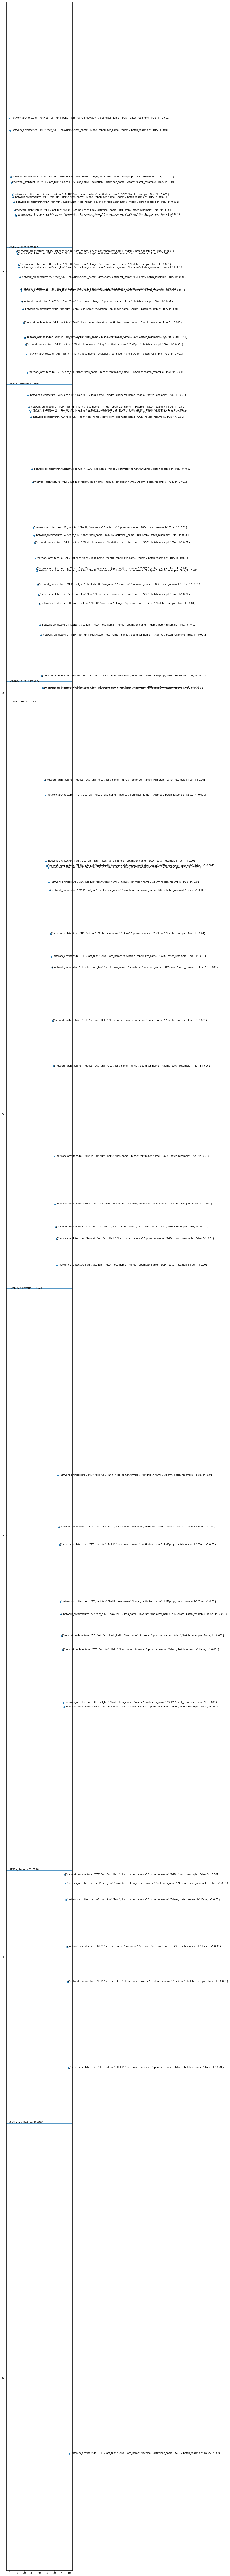

In [10]:
fig = plt.figure(figsize=(5, 200))
x = np.arange(result.shape[0])
y = result['AvePerform']
components = result['Components']

plt.scatter(x, y)
for i, (xx, yy) in enumerate(zip(x, y)):
    c = ast.literal_eval(components[i])
    plt.text(xx, yy, {_:c[_] for _ in keys_show})
    
    
for i in range(result_SOTA.shape[0]):
    plt.axhline(result_SOTA.loc[i, 'AvePerform'])
    plt.text(0, result_SOTA.loc[i, 'AvePerform'], result_SOTA.loc[i, 'Components'] + ', Perform-' + str(round(result_SOTA.loc[i, 'AvePerform'], 4)))
    
fig.savefig('天梯图-'+metric+'.pdf', dpi=300, bbox_inches='tight', pad_inches=0.01)